In [16]:
from sklearn.datasets import fetch_20newsgroups, load_digits
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from scipy.stats import multivariate_normal
from sklearn import mixture

from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score

## Поиск тем в документах

In [2]:
dataset = fetch_20newsgroups(subset='all', shuffle=True, download_if_missing=True)

texts = dataset.data # Extract text
target = dataset.target # Extract target

In [3]:
print(texts[1])

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   



In [4]:
#20 кластеров
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [5]:
embeddings_dict = {}
with open("data/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
#ключ - слово, значение - его вектор
embeddings_dict['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [7]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [8]:
closest = find_closest_embeddings(embeddings_dict["chinese"])

Многие из них действительно имеют смысл, особенно первые несколько!

In [9]:
closest[:10]

['chinese',
 'china',
 'taiwanese',
 'taiwan',
 'korean',
 'mainland',
 'japanese',
 'beijing',
 'asian',
 'hong']

Азия без Китая - Дриберген и Россия

In [10]:
find_closest_embeddings(embeddings_dict["asian"] - embeddings_dict["chinese"])[:10]

['driebergen',
 'wc2003-sri',
 'russia-1',
 'wpga',
 'dingman',
 'leapfrogging',
 'myoot',
 'inthe',
 "'02",
 'oly-2004-doping']

In [11]:
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [12]:
pca_scaled =  make_pipeline(StandardScaler(), PCA(n_components=2))
pca_features = pca_scaled.fit_transform(vectors)

In [13]:
vectors[0].shape

(50,)

In [14]:
pca_features.shape

(400000, 2)

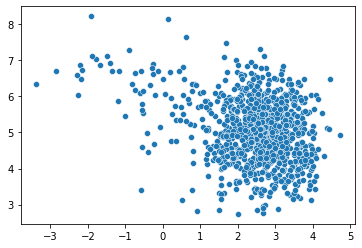

In [15]:
sns.scatterplot(x=pca_features[:1000, 0], y=pca_features[:1000, 1])

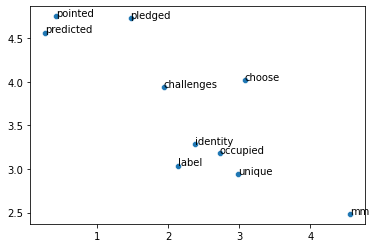

In [16]:
for label, x, y in zip(words[3000:3010], pca_features[3000:3010, 0], pca_features[3000:3010, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    
sns.scatterplot(x=pca_features[3000:3010, 0], y=pca_features[3000:3010, 1])

In [52]:
db_pred = DBSCAN(eps = 0.5, min_samples = 20).fit_predict(pca_features[:10000])
gmm_pred = mixture.GaussianMixture(n_components=20, covariance_type='full').fit_predict(pca_features[:10000])
spectral_pred = SpectralClustering(n_clusters=20).fit_predict(pca_features[:10000])

In [56]:
np.unique(spectral_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

Как-то не видны эти 20 кластеров у SpectralClustering. DBSCAN не справился

Text(0.5, 1.0, 'DBSCAN')

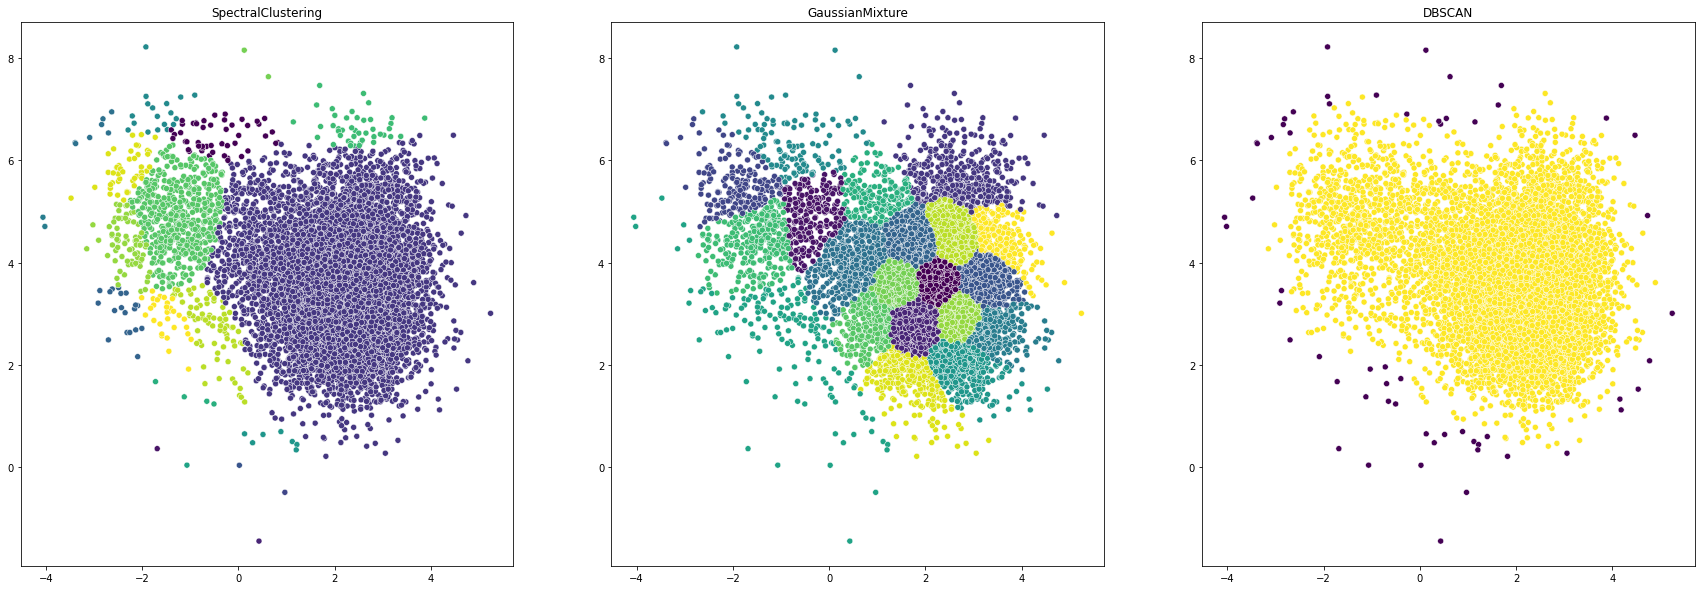

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
sns.scatterplot(x=pca_features[:10000, 0], y=pca_features[:10000, 1], c = spectral_pred, ax=ax[0])
sns.scatterplot(x=pca_features[:10000, 0], y=pca_features[:10000, 1], c = gmm_pred, ax=ax[1])
sns.scatterplot(x=pca_features[:10000, 0], y=pca_features[:10000, 1], c = db_pred, ax=ax[2])
ax[0].set_title('SpectralClustering')
ax[1].set_title('GaussianMixture')
ax[2].set_title('DBSCAN')

Силуэту не нравится, что кластеров много и даёт DBSCAN скор выше

In [62]:
print(silhouette_score(pca_features[:10000], gmm_pred))
print(silhouette_score(pca_features[:10000], db_pred))
print(silhouette_score(pca_features[:10000], spectral_pred))

0.29901253623623997
0.5301290691957359
0.26677310963731066


##  Кластеризация рукописных цифр

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [5]:
X.shape

(1797, 64)

In [6]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

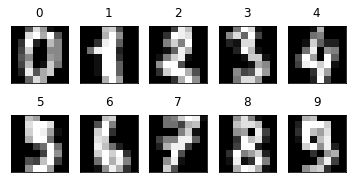

In [7]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [13]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
pca_features = PCA(n_components=2).fit_transform(X)

In [12]:
pca_features.shape

(1797, 2)

In [25]:
kmeans_pred = KMeans(n_clusters=10).fit_predict(pca_features)
db_pred = DBSCAN(eps = 0.16, min_samples = 3).fit_predict(pca_features)
gmm_pred = mixture.GaussianMixture(n_components=10, covariance_type='full').fit_predict(pca_features)
spectral_pred = SpectralClustering(n_clusters=10).fit_predict(pca_features)

In [48]:
adj_r = []
adj_m = []
v = []
silhouette = []

for i in pred:
    adj_r.append(adjusted_rand_score(i, y))
    adj_m.append(adjusted_mutual_info_score(i ,y))
    v.append(v_measure_score(i ,y))
    silhouette.append(silhouette_score(pca_features, i))

pred = [db_pred, kmeans_pred, spectral_pred, gmm_pred]
score = [adj_r, adj_m, v, silhouette]

adjusted_rand_score: DBSCAN случайно разбил на кластеры, KMeans и GM чуть менее случайно
adjusted_mutual_info_score: По этому скору KMeans, SpectralClustering, GaussianMixture более схожи с таргетом
v_measure_score: KMeans, SpectralClustering, GaussianMixture схожи с таргетом
silhouette_score: нигде нет четких кластеров, в основном накладывающиеся кластеры, а DBSCAN рандом откластеризовал

In [27]:
pd.DataFrame(score, columns = ['DBSCAN', 'KMeans', 'SpectralClustering', 'GaussianMixture'], 
             index=['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'silhouette_score'])

,DBSCAN,KMeans,SpectralClustering,GaussianMixture
adjusted_rand_score,0.000007,0.387139,0.218916,0.373712
adjusted_mutual_info_score,0.000829,0.521913,0.512603,0.523754
homogeneity_score,0.194679,0.528397,0.654601,0.535079
completeness_score,0.006259,0.524946,0.429191,0.522153
v_measure_score,0.012128,0.526666,0.518456,0.528537
silhouette_score,-0.524083,0.392601,0.067895,0.363241


Все промахиваются

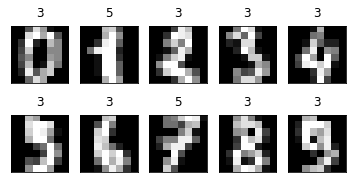

In [45]:
fig, ax = plt.subplots(figsize=(6,3))
nrows, ncols = 2, 5
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(kmeans_pred[i])

В общем, DBSCAN плохо справился (но скорее это я плохо справилась с DBSCANом)